In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate, Reshape, Add
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Model
from keras.models import load_model
from keras.models import model_from_json
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
def open_and_load(string):
    with open('trained/'+string+'.json', 'r') as f:
        model = model_from_json(f.read())
    model.load_weights('trained/'+string+'.h5')   
    return model

Using TensorFlow backend.


In [2]:
def change_gen(batch_size=128):
    while True:
        a = np.random.randn(batch_size)
        b = (a > 0)
        yield a, b       
        
i = Input(shape=(1,))
h = Dense(1, activation='relu')(i)
h = Dense(1, activation='hard_sigmoid')(h)
change2 = Model(inputs=i, outputs=h)
change2.compile(loss=mean_squared_error,
              optimizer='adam')
# change.summary()
# change2.fit_generator(change_gen(), steps_per_epoch=128000, epochs=3)

In [63]:
i = Input(shape=(3,))
h = Dense(2, use_bias=False)(i)
h = Dense(1, activation='hard_sigmoid', use_bias=False)(h)
h = Lambda(lambda s: K.concatenate([1-s,s]), output_shape=(2,))(h)
border_att = Model(inputs=i, outputs=h)
border_att.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])

In [64]:
i = Input(shape=(3,))
border_att.name = 'attention'
h = border_att(i)

b1b2 = Lambda(lambda s: s[:,:2], output_shape=(2,), name='b1b2')(i)
mul = Multiply()([h, b1b2]) 

out = Lambda(lambda s: s[:,0]+s[:,1], output_shape=(1,))(mul)
# out = Dense(1, use_bias=False)(mul)
border = Model(inputs=i, outputs=out)
border.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
border.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
attention (Model)               (None, 2)            8           input_11[0][0]                   
__________________________________________________________________________________________________
b1b2 (Lambda)                   (None, 2)            0           input_11[0][0]                   
__________________________________________________________________________________________________
multiply_2 (Multiply)           (None, 2)            0           attention[1][0]                  
                                                                 b1b2[0][0]                       
__________

In [65]:
i_b2 = Input(shape=(3,))


h_b2 = Dense(3, use_bias=False)(i_b2) #added
h_b2 = Dense(1, use_bias=False)(h_b2)

out_b2 = h_b2
# out = Dense(1, use_bias=False)(mul)
bounce = Model(inputs=i_b2, outputs=out_b2)
bounce.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
bounce.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [66]:
i_b3 = Input(shape=(3,))

h_b3 = Dense(3, use_bias=False)(i_b3) #added
h_b3 = Dense(1, use_bias=False)(h_b3)

out_b3 = h_b3
# out = Dense(1, use_bias=False)(mul)
move = Model(inputs=i_b3, outputs=out_b3)
move.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
move.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 3         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [67]:
att = open_and_load('att3') #only pretrained

In [68]:
def gen(batch_size=128):
    while True:
        a = np.zeros((batch_size,4)) #x, v, b1, b2
        a[:,1] = np.random.uniform(0,0.1,size=batch_size)
        a[:,2] = np.random.uniform(0,-10,size=batch_size)
        a[:,3] = np.random.uniform(0, 10,size=batch_size)
        i = np.random.choice([0,1], size=batch_size) #isb1
        b = a[:,2]*i + a[:,3]*(1-i)
        a[:,1] *= np.sign(1-i-0.5) 
        a[:,0] = np.random.uniform(b, b-2*a[:,1])
        
        isBounce = ( np.abs(a[:,0] + a[:,1]) - np.abs(b)) > 0
        
        v = a[:,1] * np.sign(1-isBounce-0.5) #new speed
        x = (a[:,0] + a[:,1]) * (1-isBounce) + (2*b-a[:,1]-a[:,0])*isBounce
        b_newIsb1 = ((x-a[:,2])/(a[:,3]-a[:,2])) < 0.5
        b_new = a[:,2]*b_newIsb1 + a[:,3]*(1-b_newIsb1)
        y = np.zeros((batch_size,2))
        y[:,0] = x
        y[:,1] = v       
        yield a, y     

In [69]:
def gen_2d(batch_size=128):
    while True:
        a = np.zeros((batch_size, 8))
        y = np.zeros((batch_size,4))
        a[:,:4], y[:,:2] = next(gen(batch_size=batch_size))
        a[:,4:], y[:,2:] = next(gen(batch_size=batch_size))
        yield a, y     

In [70]:
a, b = next(gen_2d())

In [71]:
i = Input(shape=(4,))

x = Lambda(lambda s: s[:,0],name='x')(i)
v = Lambda(lambda s: s[:,1],name='v')(i)
b1 = Lambda(lambda s: s[:,2],name='b1')(i)
b2 = Lambda(lambda s: s[:,3],name='b2')(i)
dropv = Lambda(lambda s: K.stack([s[0],s[1],s[2]], axis=1), output_shape=(3,),name='drop_v')([b1,b2,x])
# dropv = Concatenate(axis=1)([b1,b2])
# dropv = Reshape((3,))(dropv)
border.name='border'
getb = border(dropv)
getb = Reshape((1,))(getb)

xv = Lambda(lambda s: K.stack([s[0],s[1]], axis=1), output_shape=(2,),name='xv')([x,v])
# xv = Reshape((2,))(xv)
xvb = Concatenate(name='xvb')([xv,getb])
att.name='attention'
at = att(xvb)
# at3 = Lambda(lambda s: K.stack([s[:,0],s[:,0],s[:,0]],axis=1))(at)
bounce.name='bounce'
h3 = bounce(xvb)
v2 = Lambda(lambda s: -s, output_shape=(1,),name='new_v')(v)
h3 = Concatenate(name='bounce_concat')([h3,Reshape((1,))(v2)])
mul1 = Multiply(name='mul_att_bounce')([h3, at])

notat = Lambda(lambda s: 1-s, output_shape=(1,),name='1-att')(at)
# notat3 = Lambda(lambda s: K.stack([1-s[:,0],1-s[:,0],1-s[:,0]],axis=1))(at)
move.name='move'
g3 = move(xvb)
g3 = Concatenate(name='move_concat')([g3,Reshape((1,))(v)])
mul2 = Multiply(name='mul_att_move')([g3, notat])

out = Add(name='output')([mul1,mul2])

module = Model(inputs=i, outputs=out)
module.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])

In [72]:
inputs2d = Input(shape=(8,))

split_x = Lambda(lambda s: s[:,:4], output_shape=(4,),name='x')(inputs2d)
split_x = Reshape((4,))(split_x) #split_x.shape gives (None, 4) otherwise
model_x = module(split_x)

split_y = Lambda(lambda s: s[:,4:], output_shape=(4,1),name='y')(inputs2d)
split_y = Reshape((4,))(split_y)
model_y = module(split_y)

x = Concatenate()([model_x, model_y])

model_2d = Model(inputs=inputs2d, outputs=x)
model_2d.compile(loss=mean_squared_error,
              optimizer='adam')

In [ ]:
model_2d.fit_generator(gen_2d(),steps_per_epoch=12800,epochs=50)

Epoch 1/50
12800/12800 [==============================] - 52s 4ms/step - loss: 0.2097
Epoch 2/50
12800/12800 [==============================] - 51s 4ms/step - loss: 0.0033
Epoch 3/50
12800/12800 [==============================] - 50s 4ms/step - loss: 0.0019
Epoch 4/50
12800/12800 [==============================] - 50s 4ms/step - loss: 0.0019
Epoch 5/50
12800/12800 [==============================] - 50s 4ms/step - loss: 0.0019
Epoch 6/50
12800/12800 [==============================] - 51s 4ms/step - loss: 0.0019
Epoch 7/50
12800/12800 [==============================] - 56s 4ms/step - loss: 0.0019
Epoch 8/50
12800/12800 [==============================] - 54s 4ms/step - loss: 0.0018
Epoch 9/50
 8548/12800 [===================>..........] - ETA: 17s - loss: 0.0018

In [36]:
X, Y = next(gen(batch_size=1))
X2, Y2 = next(gen(batch_size=1))
# P = module.predict(a)

b1, b2 = X[0,2:]
c1, c2 = X2[0,2:]

X

A = np.concatenate([X,X2], axis=-1)

preds = []
# preds += [P]
# x, xv, y, yv = P
newA = A
for _ in range(10):
    P = model_2d.predict(newA)
    preds += [P[0]]
    x, xv, y, yv = P[0]
    newA = np.array([[x,xv, b1, b2, y, yv, c1, c2]])
preds = np.array(preds)

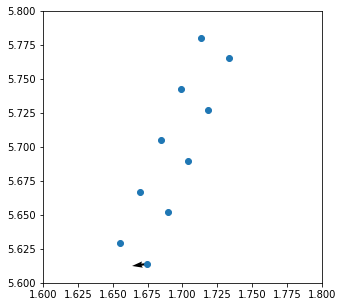

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(1.6, 1.8), ylim=(5.6, 5.8))
line = ax.plot([0,1],[0,0])

x,xv,y,yv = preds[0]
plt.quiver(x, y, xv, yv)
plt.scatter(preds[:,0], preds[:,2])
plt.plot([b1,b1],[c1,c2])

In [47]:
%matplotlib notebook

In [48]:
frames = preds

<IPython.core.display.Javascript object>


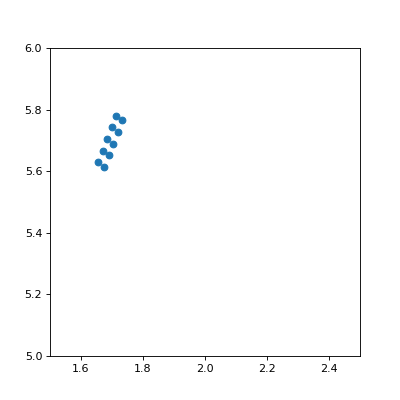

In [60]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(1.5, 2.5), ylim=(5, 6))

scat = ax.scatter( frames[:4,0], frames[:4,3])

def animate(i):
    t = np.array([frames[:i,0], frames[:i,2]]  )
    scat.set_offsets(t.T)

anim = FuncAnimation(
    fig, animate, interval=500, frames=100, repeat=False)

plt.draw()
plt.show()

In [52]:
frames

array([[ 1.6748883 , -0.09091698,  5.613918  , -0.01233546],
       [ 1.6550972 ,  0.09091698,  5.6291823 ,  0.01233546],
       [ 1.6894921 , -0.09091698,  5.651788  , -0.01233546],
       [ 1.6696926 ,  0.09091698,  5.667031  ,  0.01233546],
       [ 1.704079  , -0.09091698,  5.689615  , -0.01233546],
       [ 1.6842712 ,  0.09091698,  5.7048354 ,  0.01233546],
       [ 1.7186493 , -0.09091698,  5.7273974 , -0.01233546],
       [ 1.698833  ,  0.09091698,  5.742596  ,  0.01233546],
       [ 1.7332026 , -0.09091698,  5.7651362 , -0.01233546],
       [ 1.7133778 ,  0.09091698,  5.7803135 ,  0.01233546]],
      dtype=float32)

In [58]:
np.array([frames[:10,0], frames[:10,3]]).T

array([[ 1.6748883 , -0.01233546],
       [ 1.6550972 ,  0.01233546],
       [ 1.6894921 , -0.01233546],
       [ 1.6696926 ,  0.01233546],
       [ 1.704079  , -0.01233546],
       [ 1.6842712 ,  0.01233546],
       [ 1.7186493 , -0.01233546],
       [ 1.698833  ,  0.01233546],
       [ 1.7332026 , -0.01233546],
       [ 1.7133778 ,  0.01233546]], dtype=float32)